In [3]:
import tensorflow as tf
from tensorflow import keras
import cv2
import os
import numpy as np
import pathlib
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model

In [4]:
IMG_HEIGHT = 180
IMG_WIDTH = 180
VIDEO_FOLDER_PATH = 'videos'
PATH_FOR_IMAGES = 'images'
SEQUENCE_LENGTH=20

1. Extract frames from the video and store in new folder location in project directory

In [5]:
for folder in os.listdir(VIDEO_FOLDER_PATH):

    # TODO: Check if images folder exists, if not create it
    
    if not os.path.exists(os.path.join(PATH_FOR_IMAGES, folder)):
        os.mkdir(os.path.join(PATH_FOR_IMAGES, folder))

    for video_file in os.listdir(os.path.join(VIDEO_FOLDER_PATH, folder)):
        full_video_path = os.path.join(VIDEO_FOLDER_PATH, folder, video_file)
        video = cv2.VideoCapture(full_video_path)
        success, image = video.read()
        count = 0

        while success:
            video.set(cv2.CAP_PROP_POS_MSEC,(count*200))
            image_path = os.path.join(PATH_FOR_IMAGES, folder, "frame%d.jpg" % count)
            cv2.imwrite(image_path, image)
            success, image = video.read()
            count += 1

2. Create TensorFlow Datasets Objects consisting of images

In [6]:
PATH_FOR_IMAGES = pathlib.Path(PATH_FOR_IMAGES)
total_image_count = len(list(PATH_FOR_IMAGES.glob('**/*.jpg')))
# NOTE: Below does not need to be a tensorflow dataset
list_ds = tf.data.Dataset.list_files(str(PATH_FOR_IMAGES/'*/*.jpg'), shuffle=False)
# list_ds = list_ds.shuffle(total_image_count, reshuffle_each_iteration=False)
class_names = np.array(sorted([item.name for item in PATH_FOR_IMAGES.glob('*') if item.is_dir()]))

# Creating Dataset partitions
# TODO: Create test partition
validation_percentage = 0.2
validation_set_size = int(total_image_count * validation_percentage)
training_set_size = total_image_count - validation_set_size
validation_set = list_ds.take(validation_set_size)
training_set = list_ds.skip(validation_set_size)

print(tf.data.experimental.cardinality(training_set).numpy())
print(tf.data.experimental.cardinality(validation_set).numpy())



230
57


3. Create image, label pair data points

In [9]:
def extract_label_from_path(image_path):
    parts = tf.strings.split(image_path, os.path.sep)
    one_hot = tf.dtypes.cast(parts[-2] == class_names, tf.int16)
    # NOTE: Converting back tensor to numpy array, as the tensor is not serializable
    return tf.argmax(one_hot).numpy()


def decode_image(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

def process_path(image_path):
    img = tf.io.read_file(image_path)
    img = decode_image(img)
    return img

# Loop through the image path list and load the images in batches containing 20 images
# Each batch is assigned a label based on the predominant class in the batch
# Repeat the process for the entire image path list offsetting the iteration by the sequence length
def create_dataset(list_of_images):
    full_dataset_images = []
    full_dataset_labels = []
    temp_set = []
    temp_labels = []
    for image_path in list_of_images:
        if len(temp_set) == SEQUENCE_LENGTH:
            main_label = max(set(temp_labels), key=temp_labels.count)
            full_dataset_images.append(temp_set)
            full_dataset_labels.append(main_label)
            temp_set = []
            temp_labels = []
        else:
            temp_set.append(process_path(image_path))
            temp_labels.append(extract_label_from_path(image_path))
    return np.asarray(full_dataset_images), tf.keras.utils.to_categorical(np.asarray(full_dataset_labels))


train_ds = create_dataset(training_set)
validation_ds = create_dataset(validation_set)

# NOTE: Create a tensorflow dataset from training set and validation set using tf.data.Dataset.from_generator
# train_ds = tf.data.Dataset.from_generator(
#     train_ds,
#     output_types=(tf.float32, tf.int16),
#     output_shapes=((IMG_HEIGHT, IMG_WIDTH, 3), tf.int16)
# )

# train_ds = training_set.map(load_image_batch, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# validation_ds = validation_set.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# train_ds = train_ds.batch(SEQUENCE_LENGTH, drop_remainder=True).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# validation_ds = validation_ds.batch(SEQUENCE_LENGTH, drop_remainder=True).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [10]:
for i in train_ds:
    print(i)

[[[[[0.37363836 0.5142702  0.5495643 ]
    [0.36732027 0.5176471  0.54934645]
    [0.3667756  0.52200437 0.5545752 ]
    ...
    [0.29172102 0.6603485  0.7074073 ]
    [0.29346398 0.6542483  0.7052287 ]
    [0.28627452 0.64705884 0.7058824 ]]

   [[0.34564272 0.5294118  0.5686275 ]
    [0.34346408 0.5277778  0.5669935 ]
    [0.33376908 0.53093684 0.5666667 ]
    ...
    [0.29172102 0.6603485  0.7074073 ]
    [0.2895424  0.65816987 0.7052287 ]
    [0.28627452 0.64705884 0.7058824 ]]

   [[0.31176472 0.54509807 0.5921569 ]
    [0.32124186 0.5604576  0.6055556 ]
    [0.3282135  0.5752723  0.6227669 ]
    ...
    [0.29172102 0.6603485  0.7074073 ]
    [0.2895424  0.65816987 0.7052287 ]
    [0.28518522 0.64705884 0.7058824 ]]

   ...

   [[0.59738564 0.5816994  0.5385621 ]
    [0.5686275  0.5529412  0.50980395]
    [0.601634   0.58594775 0.5428105 ]
    ...
    [0.4775597  0.46579498 0.43050086]
    [0.45980382 0.4480391  0.412745  ]
    [0.43442267 0.43442267 0.38736385]]

   [[0.5554466  

In [ ]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size=32)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
validation_ds = configure_for_performance(validation_ds)



In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
print(image_batch.shape)

for j, images in enumerate(image_batch):
    for i in range(9):
     ax = plt.subplot(3, 3, i + 1)
     plt.imshow(images[i].numpy().astype("uint8"))
     label = label_batch[j][i]
     plt.title(class_names[label])
     plt.axis("off")


4. Neural Network Implementation
* We might not need to actually shuffle the dataset as we want to capture temporal relationship
* Need to consider the sequence length 


In [11]:
model = keras.Sequential()

model.add(keras.layers.ConvLSTM2D(filters=16, kernel_size=(3, 3), activation="tanh",  padding='same', recurrent_dropout=0.2, return_sequences=True, input_shape=(SEQUENCE_LENGTH, IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
model.add(keras.layers.TimeDistributed(keras.layers.Dropout(0.2)))

model.add(keras.layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), activation="tanh",  padding='same', recurrent_dropout=0.2, return_sequences=True))
model.add(keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
model.add(keras.layers.TimeDistributed(keras.layers.Dropout(0.2)))

model.add(keras.layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), activation="tanh",  padding='same', recurrent_dropout=0.2, return_sequences=True))
model.add(keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
model.add(keras.layers.TimeDistributed(keras.layers.Dropout(0.2)))

model.add(keras.layers.ConvLSTM2D(filters=128, kernel_size=(3, 3), activation="tanh",  padding='same', recurrent_dropout=0.2, return_sequences=True))
model.add(keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(len(class_names), activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 20, 180, 180, 16)  11008     
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 20, 90, 90, 16)    0         
_________________________________________________________________
time_distributed (TimeDistri (None, 20, 90, 90, 16)    0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 20, 90, 90, 32)    55424     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 20, 45, 45, 32)    0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 45, 45, 32)    0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 20, 45, 45, 64)    2

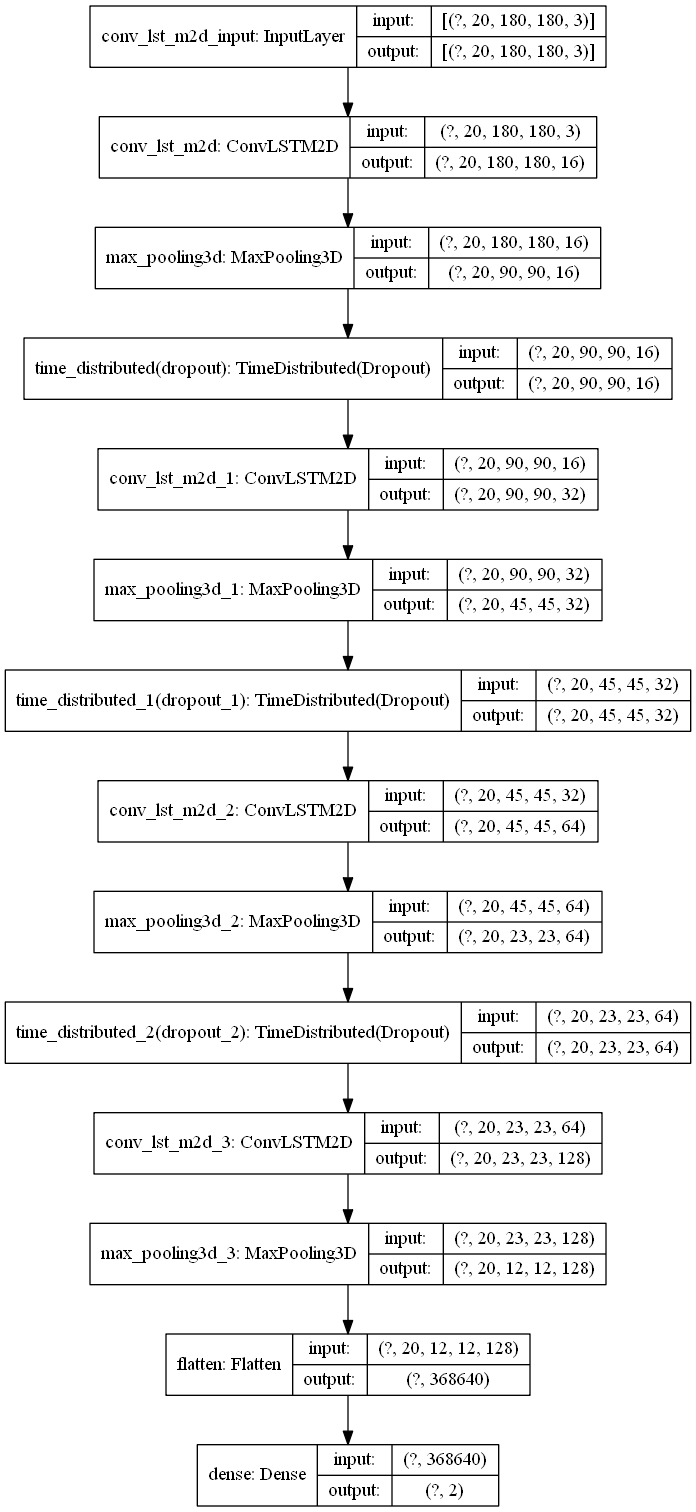

In [12]:
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

hist = model.fit(x=train_ds[0], y=train_ds[1], epochs=10, batch_size=10, validation_data=validation_ds)